In [1]:
# import modules
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xgboost as xgb

%matplotlib inline

# load data
train_variants = pd.read_csv('training_variants', sep = ',')
test_variants = pd.read_csv('test_variants', sep = ',')
train_text = pd.read_csv('training_text', sep = '\|\|', skiprows=1, engine='python', names=["ID","text"])
test_text = pd.read_csv('test_text', sep = '\|\|', skiprows=1, engine='python' ,names=["ID","text"])

In [2]:
# combine variant and text datasets
train = train_variants.merge(train_text, on='ID', how='left')
test = test_variants.merge(test_text, on='ID', how='left')

ID = test.ID

In [3]:
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (3321, 5)
test shape:  (5668, 4)


In [4]:
train.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [5]:
combined = pd.concat([train, test], axis=0)

print('Number of Unique Genes: ', combined.Gene.nunique())
print('Number of Unique Variations: ', combined.Variation.nunique())

combined.Gene.unique()

Number of Unique Genes:  1507
Number of Unique Variations:  8609


array(['FAM58A', 'CBL', 'SHOC2', ..., 'CD96', 'HPS3', 'DFNB59'], dtype=object)

In [6]:
# Remove useless symbols from description
def clean(s):    
    # Remove any tags:
    cleaned = re.sub(r"(?s)<.?>", " ", s)
    # Keep only regular chars:
    cleaned = re.sub(r"[^A-Za-z0-9(),*!?\'\`]", " ", cleaned)
    # Remove unicode chars
    cleaned = re.sub("\\\\u(.){4}", " ", cleaned)
    
    return cleaned.strip()

# clean text
train['clean_text'] = train.text.apply(lambda x: clean(x))
test['clean_text'] = test.text.apply(lambda x: clean(x))

# convert Gene, Variation, and text to lowercase
train['clean_text'] = train.clean_text.str.lower()
test['clean_text'] = test.clean_text.str.lower()

train['Gene'] = train.Gene.str.lower()
test['Gene'] = test.Gene.str.lower()

train['Variation'] = train.Variation.str.lower()
test['Variation'] = test.Variation.str.lower()

# create list of all words in text
train['text_list'] = train.clean_text.str.split(' ')
test['text_list'] = test.clean_text.str.split(' ')

In [7]:
# # this code is correct, but it takes awhile to run. I've therefore saved
# # it's results to a .csv file (parsed_data.csv) where I will upload from
# # to increase iteration speed.
#######

# # only find text surrounding the mutation's Variation (i.e. within +/- 250 words)
# def textParser(df):
#     n = 250
#     df['text_list_parsed'] = ''
    
#     end = len(df['text_list'])
#     text_list_parsed = []
#     final_text_list_parsed = []

#     print(df['Variation'])
#     for spot in range(end):
# #         if ' ' in df['Variation']:
# #             df['Variation'] = df['Variation'].split(' ')[0]
# #             print(df['Variation'])
            
# #         if df['Variation'] in df['text_list'][spot]:
#         if df['Variation'].split(' ')[0] in df['text_list'][spot]:
#             if spot - n > 0:
#                 start = spot - n
#             else:
#                 start = 0
#             if spot + n < end:
#                 stop = spot + n
#             else:
#                 stop = end
#             text_list_parsed.append([start, stop, spot])

#     for i in range(len(text_list_parsed)):
#         if (i < len(text_list_parsed) - 1) and (text_list_parsed[i][1] > text_list_parsed[i+1][0]):
#             text_list_parsed[i+1][0] = text_list_parsed[i][0]
#         else:
#             final_text_list_parsed.append(df['text_list'][text_list_parsed[i][0] : text_list_parsed[i][1]])
#             print(text_list_parsed[i][0], text_list_parsed[i][1])

#     final_text_list_parsed = [val for sublist in final_text_list_parsed for val in sublist]
#     df['text_list_parsed'] = final_text_list_parsed
#     df['text_parsed'] = ' '.join(df['text_list_parsed'])
    
#     print(df['text_parsed'][:50])
#     print()
    
#     return df

# train = train.apply(textParser, axis=1)
# test = test.apply(textParser, axis=1)

In [8]:
# saved = pd.concat([train, test], axis=0)
# saved = saved[['text_list_parsed', 'text_parsed']]
# saved.to_csv('parsed_data.csv', index=False)

In [9]:
# load parsed text data from saved file
parsed = pd.read_csv('parsed_data.csv')
train_parsed = parsed[:len(train)].reset_index(drop=True)
test_parsed = parsed[len(train):].reset_index(drop=True)

train = pd.concat([train, train_parsed], axis=1)
test = pd.concat([test, test_parsed], axis=1)

train['text_parsed'] = train['text_parsed'].fillna('')
test['text_parsed'] = test['text_parsed'].fillna('')

train.head()

,ID,Gene,Variation,Class,text,clean_text,text_list,text_list_parsed,text_parsed
0,0,fam58a,truncating mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,cyclin dependent kinases (cdks) regulate a var...,"[cyclin, dependent, kinases, (cdks), regulate,...",[],
1,1,cbl,w802*,2,Abstract Background Non-small cell lung canc...,abstract background non small cell lung cance...,"[abstract, background, , non, small, cell, lun...","['abstract', 'background', '', 'non', 'small',...",abstract background non small cell lung cance...
2,2,cbl,q249e,2,Abstract Background Non-small cell lung canc...,abstract background non small cell lung cance...,"[abstract, background, , non, small, cell, lun...","['abstract', 'background', '', 'non', 'small',...",abstract background non small cell lung cance...
3,3,cbl,n454d,3,Recent evidence has demonstrated that acquired...,recent evidence has demonstrated that acquired...,"[recent, evidence, has, demonstrated, that, ac...","['identified', 'in', '26', 'patients,', 'of', ...","identified in 26 patients, of whom 3 had mf, 1..."
4,4,cbl,l399v,4,Oncogenic mutations in the monomeric Casitas B...,oncogenic mutations in the monomeric casitas b...,"[oncogenic, mutations, in, the, monomeric, cas...","['resulted', 'in', 'a', 'significant', 'increa...",resulted in a significant increase in egf stim...


In [10]:
# combine like-words in Variation
def remove_Var_Redundancy(df):
    for i in ['deletions', 'deletion']:
        df['Variation'] = df['Variation'].replace(to_replace=i, value='del')

    for i in ['delins', 'intsertions/deletions', 'insertions/deletions']:
        df['Variation'] = df['Variation'].replace(to_replace=i, value='deletion/insertion')

    for i in ['insertions', 'insertion']:
        df['Variation'] = df['Variation'].replace(to_replace=i, value='ins')

    for i in ['duplications', 'duplication']:
        df['Variation'] = df['Variation'].replace(to_replace=i, value='dup')
            
    return df

train = remove_Var_Redundancy(train)
test = remove_Var_Redundancy(test)

print(train.shape)
print(test.shape)

(3321, 9)
(5668, 8)


In [11]:
combined = pd.concat([train, test], axis=0)

# find most common genes
gene_pop = combined.groupby(['Gene'])['clean_text'].count().sort_values(ascending=False)
gene_popularity = dict(zip(np.array(gene_pop.index), gene_pop.values))

gene_pop[:10]

Gene
brca1    293
tp53     182
egfr     157
pten     146
brca2    141
f8       134
kit      110
braf     104
alk       77
erbb2     76
Name: clean_text, dtype: int64

In [12]:
# create feature that indicates gene 'popularity'
train['gene_pop'] = [gene_popularity.get(train['Gene'].loc[i]) for i in range(len(train))]
test['gene_pop'] = [gene_popularity.get(test['Gene'].loc[i]) for i in range(len(test))]

train['gene_pop'][:15]

0      1
1     27
2     27
3     27
4     27
5     27
6     27
7     27
8     27
9     27
10    27
11    27
12    27
13    27
14    27
Name: gene_pop, dtype: int64

In [13]:
combined = pd.concat([train, test], axis=0)

# find most common variations
var_pop = combined.groupby(['Variation'])['clean_text'].count().sort_values(ascending=False)
var_popularity = dict(zip(np.array(var_pop.index), var_pop.values))

var_pop[:100]

Variation
truncating mutations    111
del                      88
amplification            79
fusions                  37
overexpression            6
g12v                      4
q61r                      4
e17k                      3
g13d                      3
t58i                      3
q61h                      3
q61l                      3
g12c                      3
g12d                      3
p34r                      2
a59g                      2
t167a                     2
g44d                      2
f384l                     2
v321m                     2
p130s                     2
r183q                     2
s222d                     2
y42c                      2
q22k                      2
ewsr1-erg fusion          2
ewsr1-etv1 fusion         2
t73i                      2
etv6-ntrk3 fusion         2
g35r                      2
                       ... 
h123l                     1
h101r                     1
h1047l                    1
h123p                     1
h123q     

In [14]:
# create feature that indicates variation 'popularity'
train['var_pop'] = [var_popularity.get(train['Variation'].loc[i]) for i in range(len(train))]
test['var_pop'] = [var_popularity.get(test['Variation'].loc[i]) for i in range(len(test))]

train['var_pop'][:15]

0     111
1       1
2       1
3       1
4       1
5       1
6       1
7      88
8       1
9       1
10      1
11      1
12      1
13      1
14      1
Name: var_pop, dtype: int64

In [16]:
# create features from text meta data
def wordFeatures(df):
    # count number of characters in text
    df['char_count_total'] = df.clean_text.str.len()
    df['char_count_parsed'] = df.text_parsed.str.len()

    # count number of characters removed
    df['char_count_dirty'] = df.text.str.len() - df.clean_text.str.len()
    df['char_count_unparsed'] = df.clean_text.str.len() - df.text_parsed.str.len()

    # count number of words in text
    df['word_count_total'] = df.text_list.str.len()
    df['word_count_parsed'] = df.text_list_parsed.str.len()

    # find average word length in text
    df['avg_word_len_total'] = df.char_count_total / df.word_count_total
    df['avg_word_len_total'] = df['avg_word_len_total'].replace(np.inf, np.nan)
    df['avg_word_len_parsed'] = df.char_count_parsed / df.word_count_parsed    
    df['avg_word_len_parsed'][df['avg_word_len_parsed'].isnull()] = df['avg_word_len_total'][df['avg_word_len_parsed'].isnull()]
    
    df['perc_word_unparsed'] = df.char_count_unparsed / df.char_count_total
    df['ratio_char_parsed'] = df.char_count_parsed / df.char_count_unparsed
    
    # count number of words in Variation
    df['var_word_count'] = df.Variation.str.split().str.len()

    # find Gene word length
    df['Gene_length'] = df.Gene.str.len()

    # find Variation word length
    df['Variation_length'] = df.Variation.str.len()

    return df

train = wordFeatures(train)
test = wordFeatures(test)

train.head()

/Users/JPhilleo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ID,Gene,Variation,Class,text,clean_text,text_list,text_list_parsed,text_parsed,gene_pop,...,char_count_unparsed,word_count_total,word_count_parsed,avg_word_len_total,avg_word_len_parsed,perc_word_unparsed,ratio_char_parsed,var_word_count,Gene_length,Variation_length
0,0,fam58a,truncating mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,cyclin dependent kinases (cdks) regulate a var...,"[cyclin, dependent, kinases, (cdks), regulate,...",[],,1,...,39671,6880,2,5.766134,0.000000,1.000000,0.000000,2,6,20
1,1,cbl,w802*,2,Abstract Background Non-small cell lung canc...,abstract background non small cell lung cance...,"[abstract, background, , non, small, cell, lun...","['abstract', 'background', '', 'non', 'small',...",abstract background non small cell lung cance...,27,...,12229,6722,37730,5.458048,0.648290,0.333315,2.000164,1,3,5
2,2,cbl,q249e,2,Abstract Background Non-small cell lung canc...,abstract background non small cell lung cance...,"[abstract, background, , non, small, cell, lun...","['abstract', 'background', '', 'non', 'small',...",abstract background non small cell lung cance...,27,...,12154,6722,37793,5.458048,0.649194,0.331271,2.018677,1,3,5
3,3,cbl,n454d,3,Recent evidence has demonstrated that acquired...,recent evidence has demonstrated that acquired...,"[recent, evidence, has, demonstrated, that, ac...","['identified', 'in', '26', 'patients,', 'of', ...","identified in 26 patients, of whom 3 had mf, 1...",27,...,23095,6086,19650,5.954157,0.668804,0.637332,0.569041,1,3,5
4,4,cbl,l399v,4,Oncogenic mutations in the monomeric Casitas B...,oncogenic mutations in the monomeric casitas b...,"[oncogenic, mutations, in, the, monomeric, cas...","['resulted', 'in', 'a', 'significant', 'increa...",resulted in a significant increase in egf stim...,27,...,38048,6953,4967,5.940889,0.656130,0.921103,0.085655,1,3,5


In [17]:
# print sorted (ABC) list of all Genes in train set
train.Gene.sort_values().unique()

# many Genes are related or similar, and follow a similar naming convention:
# letters, number
# letters, number, letters
# letters, number, -, letters
# letters, number, -, numbers

array(['abl1', 'acvr1', 'ago2', 'akt1', 'akt2', 'akt3', 'alk', 'apc', 'ar',
       'araf', 'arid1a', 'arid1b', 'arid2', 'arid5b', 'asxl1', 'asxl2',
       'atm', 'atr', 'atrx', 'aurka', 'aurkb', 'axin1', 'axl', 'b2m',
       'bap1', 'bard1', 'bcl10', 'bcl2', 'bcl2l11', 'bcor', 'braf',
       'brca1', 'brca2', 'brd4', 'brip1', 'btk', 'card11', 'carm1',
       'casp8', 'cbl', 'ccnd1', 'ccnd2', 'ccnd3', 'ccne1', 'cdh1', 'cdk12',
       'cdk4', 'cdk6', 'cdk8', 'cdkn1a', 'cdkn1b', 'cdkn2a', 'cdkn2b',
       'cdkn2c', 'cebpa', 'chek2', 'cic', 'crebbp', 'ctcf', 'ctla4',
       'ctnnb1', 'ddr2', 'dicer1', 'dnmt3a', 'dnmt3b', 'dusp4', 'egfr',
       'eif1ax', 'elf3', 'ep300', 'epas1', 'epcam', 'erbb2', 'erbb3',
       'erbb4', 'ercc2', 'ercc3', 'ercc4', 'erg', 'errfi1', 'esr1', 'etv1',
       'etv6', 'ewsr1', 'ezh2', 'fam58a', 'fanca', 'fancc', 'fat1',
       'fbxw7', 'fgf19', 'fgf3', 'fgf4', 'fgfr1', 'fgfr2', 'fgfr3',
       'fgfr4', 'flt1', 'flt3', 'foxa1', 'foxl2', 'foxo1', 'foxp1',
       '

In [18]:
# Segment Gene data into its rightful components. For example:
# RAD51B --> RAD, 51, B
# YAP1 --> YAP, 1
# WHSC1L1 --> WHSC, 1, L, 1


# determine if string character is an integer
def isInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

# segment gene into four parts (no genes have more than that)
def gene_Segment(df):
    first_letters = []
    first_nums = []
    second_letters = []
    second_nums = []
    
    for char in df.Gene:
        if isInt(char) == False and len(first_nums) == 0:
            first_letters.append(char)
        if isInt(char) == True and len(second_letters) == 0:
            first_nums.append(char)
        if isInt(char) == False and len(first_nums) != 0:
            second_letters.append(char)
        if isInt(char) == True and len(second_letters) != 0:
            second_nums.append(char)
        continue

    df['gene_1st_letters'] = ''.join(first_letters)
    df['gene_1st_nums'] = ''.join(first_nums)
    df['gene_2nd_letters'] = ''.join(second_letters)
    df['gene_2nd_nums'] = ''.join(second_nums)
    
    return df

train = train.apply(gene_Segment, axis=1)
test = test.apply(gene_Segment, axis=1)

In [19]:
# Segment Variation data into its rightful components.
def var_Segment(df):
    first_letters = []
    first_nums = []
    second_letters = []
    second_nums = []
    third_letters = []
    third_nums = []
# using six parts because some Variations have that many
    
    for char in df.Variation:
        if isInt(char) == False and len(first_nums) == 0:
            first_letters.append(char)
        if isInt(char) == True and len(second_letters) == 0:
            first_nums.append(char)
        if isInt(char) == False and len(first_nums) != 0:
            second_letters.append(char)
        if isInt(char) == True and len(second_letters) != 0:
            second_nums.append(char)
        if isInt(char) == False and len(second_nums) != 0:
            third_letters.append(char)
        if isInt(char) == True and len(third_letters) != 0:
            third_nums.append(char)
        continue

    df['var_1st_letters'] = ''.join(first_letters)
    df['var_1st_nums'] = ''.join(first_nums)
    df['var_2nd_letters'] = ''.join(second_letters)
    df['var_2nd_nums'] = ''.join(second_nums)
    df['var_3rd_letters'] = ''.join(third_letters)
    df['var_3rd_nums'] = ''.join(third_nums)
    
    return df

train = train.apply(var_Segment, axis=1)
test = test.apply(var_Segment, axis=1)

In [20]:
print('Number of Unique Train Gene 1st Letters: ', train.gene_1st_letters.nunique())
print('Number of Unique Train Genes: ', train.Gene.nunique())
print()
print('Number of Unique Test Gene 1st Letters: ', test.gene_1st_letters.nunique())
print('Number of Unique Test Genes: ', test.Gene.nunique())

Number of Unique Train Gene 1st Letters:  197
Number of Unique Train Genes:  264

Number of Unique Test Gene 1st Letters:  1007
Number of Unique Test Genes:  1397


In [21]:
print('Number of Unique Train Variation 1st Letters: ', train.var_1st_letters.nunique())
print('Number of Unique Train Variation: ', train.Variation.nunique())
print()
print('Number of Unique Test Variation 1st Letters: ', test.var_1st_letters.nunique())
print('Number of Unique Test Variation: ', test.Variation.nunique())

train.head()

Number of Unique Train Variation 1st Letters:  158
Number of Unique Train Variation:  2996

Number of Unique Test Variation 1st Letters:  39
Number of Unique Test Variation:  5628


,ID,Gene,Variation,Class,text,clean_text,text_list,text_list_parsed,text_parsed,gene_pop,...,gene_1st_letters,gene_1st_nums,gene_2nd_letters,gene_2nd_nums,var_1st_letters,var_1st_nums,var_2nd_letters,var_2nd_nums,var_3rd_letters,var_3rd_nums
0,0,fam58a,truncating mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,cyclin dependent kinases (cdks) regulate a var...,"[cyclin, dependent, kinases, (cdks), regulate,...",[],,1,...,fam,58,a,,truncating mutations,,,,,
1,1,cbl,w802*,2,Abstract Background Non-small cell lung canc...,abstract background non small cell lung cance...,"[abstract, background, , non, small, cell, lun...","['abstract', 'background', '', 'non', 'small',...",abstract background non small cell lung cance...,27,...,cbl,,,,w,802,*,,,
2,2,cbl,q249e,2,Abstract Background Non-small cell lung canc...,abstract background non small cell lung cance...,"[abstract, background, , non, small, cell, lun...","['abstract', 'background', '', 'non', 'small',...",abstract background non small cell lung cance...,27,...,cbl,,,,q,249,e,,,
3,3,cbl,n454d,3,Recent evidence has demonstrated that acquired...,recent evidence has demonstrated that acquired...,"[recent, evidence, has, demonstrated, that, ac...","['identified', 'in', '26', 'patients,', 'of', ...","identified in 26 patients, of whom 3 had mf, 1...",27,...,cbl,,,,n,454,d,,,
4,4,cbl,l399v,4,Oncogenic mutations in the monomeric Casitas B...,oncogenic mutations in the monomeric casitas b...,"[oncogenic, mutations, in, the, monomeric, cas...","['resulted', 'in', 'a', 'significant', 'increa...",resulted in a significant increase in egf stim...,27,...,cbl,,,,l,399,v,,,


In [22]:
combined = pd.concat([train, test], axis=0)

print('max gene length: ')
print(combined.Gene.str.len().sort_values(ascending=False)[:5])
print()
print('max variation length: ')
print(combined.Variation.str.len().sort_values(ascending=False)[:20])

max gene length: 
3929    9
3334    9
5374    9
2811    9
4663    9
Name: Gene, dtype: int64

max variation length: 
3078    55
1676    40
3073    39
480     37
1677    36
1682    34
1640    33
1679    31
1118    30
428     29
412     28
732     28
1654    28
929     26
169     26
48      25
3256    25
1410    23
1643    23
951     22
Name: Variation, dtype: int64


In [23]:
print('train: ', train.shape)
print('test: ', test.shape)

train:  (3321, 34)
test:  (5668, 33)


In [24]:
# Ravels Genes and Variations by their segments
gene_columns = ['gene_1st_letters', 'gene_1st_nums', 'gene_2nd_letters', 'gene_2nd_nums']
var_columns = ['var_1st_letters', 'var_1st_nums', 'var_2nd_letters', 'var_2nd_nums',
              'var_3rd_letters', 'var_3rd_nums']

def segment_Breaker(df, columns):
    for column in columns:
        for char in range(min(train[column].str.len().max(), 10)):
#         for char in range(min(train[column].str.len().max(), 6)):
            column_value = []
            for element in df[column]:
                if len(element) > char:
                    column_value.append(element[char])
                else:
                    column_value.append('')
            df[column + '_' + str(char)] = column_value
    return df

combined = pd.concat([train, test], axis=0)

train = segment_Breaker(train, gene_columns)
train = segment_Breaker(train, var_columns)
test = segment_Breaker(test, gene_columns)
test = segment_Breaker(test, var_columns)

train.head()

,ID,Gene,Variation,Class,text,clean_text,text_list,text_list_parsed,text_parsed,gene_pop,...,var_3rd_letters_1,var_3rd_letters_2,var_3rd_letters_3,var_3rd_letters_4,var_3rd_letters_5,var_3rd_letters_6,var_3rd_letters_7,var_3rd_letters_8,var_3rd_letters_9,var_3rd_nums_0
0,0,fam58a,truncating mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,cyclin dependent kinases (cdks) regulate a var...,"[cyclin, dependent, kinases, (cdks), regulate,...",[],,1,...,,,,,,,,,,
1,1,cbl,w802*,2,Abstract Background Non-small cell lung canc...,abstract background non small cell lung cance...,"[abstract, background, , non, small, cell, lun...","['abstract', 'background', '', 'non', 'small',...",abstract background non small cell lung cance...,27,...,,,,,,,,,,
2,2,cbl,q249e,2,Abstract Background Non-small cell lung canc...,abstract background non small cell lung cance...,"[abstract, background, , non, small, cell, lun...","['abstract', 'background', '', 'non', 'small',...",abstract background non small cell lung cance...,27,...,,,,,,,,,,
3,3,cbl,n454d,3,Recent evidence has demonstrated that acquired...,recent evidence has demonstrated that acquired...,"[recent, evidence, has, demonstrated, that, ac...","['identified', 'in', '26', 'patients,', 'of', ...","identified in 26 patients, of whom 3 had mf, 1...",27,...,,,,,,,,,,
4,4,cbl,l399v,4,Oncogenic mutations in the monomeric Casitas B...,oncogenic mutations in the monomeric casitas b...,"[oncogenic, mutations, in, the, monomeric, cas...","['resulted', 'in', 'a', 'significant', 'increa...",resulted in a significant increase in egf stim...,27,...,,,,,,,,,,


In [25]:
train.columns.values

# Might want to remove all columns with more than .95 NaNs
# -- they probably won't be useful

array(['ID', 'Gene', 'Variation', 'Class', 'text', 'clean_text',
       'text_list', 'text_list_parsed', 'text_parsed', 'gene_pop',
       'var_pop', 'char_count_total', 'char_count_parsed',
       'char_count_dirty', 'char_count_unparsed', 'word_count_total',
       'word_count_parsed', 'avg_word_len_total', 'avg_word_len_parsed',
       'perc_word_unparsed', 'ratio_char_parsed', 'var_word_count',
       'Gene_length', 'Variation_length', 'gene_1st_letters',
       'gene_1st_nums', 'gene_2nd_letters', 'gene_2nd_nums',
       'var_1st_letters', 'var_1st_nums', 'var_2nd_letters',
       'var_2nd_nums', 'var_3rd_letters', 'var_3rd_nums',
       'gene_1st_letters_0', 'gene_1st_letters_1', 'gene_1st_letters_2',
       'gene_1st_letters_3', 'gene_1st_letters_4', 'gene_1st_letters_5',
       'gene_1st_nums_0', 'gene_1st_nums_1', 'gene_1st_nums_2',
       'gene_2nd_letters_0', 'gene_2nd_letters_1', 'gene_2nd_nums_0',
       'gene_2nd_nums_1', 'var_1st_letters_0', 'var_1st_letters_1',
       '

In [27]:
combined = pd.concat([train, test], axis=0)

print('max gene length: ')
print(combined.Gene.str.len().sort_values(ascending=False)[:5])
print()
print('max variation length: ')
print(combined.Variation.str.len().sort_values(ascending=False)[:10])

max gene length: 
3929    9
3334    9
5374    9
2811    9
4663    9
Name: Gene, dtype: int64

max variation length: 
3078    55
1676    40
3073    39
480     37
1677    36
1682    34
1640    33
1679    31
1118    30
428     29
Name: Variation, dtype: int64


In [28]:
different_variations = ['truncating mutations', 'deletion', 'promoter mutations',
                        'amplification', 'promoter hypermethylation', 'overexpression',
                       'copy number loss']

# # *** might want to use this mixed_variations instead ***
# mixed_variations = ['Del', 'Deletion/Insertion', 'Ins', 'Dup', 'Fusion',
#                     'missense', 'splice', 'domain', 'binding', 'Polymorphism']

mixed_variations = ['del', 'deletion/Insertion', 'ins', 'dup', 'fusion',
                    'splice', 'polymorphism']


# split gene and variation into individual 1-sized components (to understand what the
# words and letters mean). Do not do this for variations with 'special' designations.
def gene_breaker(df):
    for i in range(6):
        df['Gene_' + str(i)] = df['Gene'].map(lambda x: str(x[i]) if len(x) > i else '')
    return df

def variation_breaker(df):
    for i in different_variations:
        if i in df['Variation']:
            df[str(i) + '_var_breaker'] = 1
        else:
            df[str(i) + '_var_breaker'] = 0
            for j in range(10):
                df['Variation_' + str(j)] = df['Variation'].map(lambda x: str(x[j]) if len(x) > j else '')

    for i in mixed_variations:
        if i in df['Variation']:
            df[str(i) + '_var_breaker'] = 1
        else:
            df[str(i) + '_var_breaker'] = 0

    return df
    
train = gene_breaker(train)
test = gene_breaker(test)
train = variation_breaker(train)
test = variation_breaker(test)

print('train: ', train.shape)
print('test: ', test.shape)

train.head()

train:  (3321, 116)
test:  (5668, 115)


,ID,Gene,Variation,Class,text,clean_text,text_list,text_list_parsed,text_parsed,gene_pop,...,promoter hypermethylation_var_breaker,overexpression_var_breaker,copy number loss_var_breaker,del_var_breaker,deletion/Insertion_var_breaker,ins_var_breaker,dup_var_breaker,fusion_var_breaker,splice_var_breaker,polymorphism_var_breaker
0,0,fam58a,truncating mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,cyclin dependent kinases (cdks) regulate a var...,"[cyclin, dependent, kinases, (cdks), regulate,...",[],,1,...,0,0,0,0,0,0,0,0,0,0
1,1,cbl,w802*,2,Abstract Background Non-small cell lung canc...,abstract background non small cell lung cance...,"[abstract, background, , non, small, cell, lun...","['abstract', 'background', '', 'non', 'small',...",abstract background non small cell lung cance...,27,...,0,0,0,0,0,0,0,0,0,0
2,2,cbl,q249e,2,Abstract Background Non-small cell lung canc...,abstract background non small cell lung cance...,"[abstract, background, , non, small, cell, lun...","['abstract', 'background', '', 'non', 'small',...",abstract background non small cell lung cance...,27,...,0,0,0,0,0,0,0,0,0,0
3,3,cbl,n454d,3,Recent evidence has demonstrated that acquired...,recent evidence has demonstrated that acquired...,"[recent, evidence, has, demonstrated, that, ac...","['identified', 'in', '26', 'patients,', 'of', ...","identified in 26 patients, of whom 3 had mf, 1...",27,...,0,0,0,0,0,0,0,0,0,0
4,4,cbl,l399v,4,Oncogenic mutations in the monomeric Casitas B...,oncogenic mutations in the monomeric casitas b...,"[oncogenic, mutations, in, the, monomeric, cas...","['resulted', 'in', 'a', 'significant', 'increa...",resulted in a significant increase in egf stim...,27,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# count how often the Gene is mentioned in text
def find_Gene(df):
    df['Gene_Share'] = df.apply(lambda x: x['clean_text'].count(x['Gene']), axis=1)
    return df

# count how often the Variation is mentioned in text
def find_Variation(df):
    df['Variation_Share'] = df.apply(lambda x: x['clean_text'].count(x['Variation']), axis=1)
    return df

train = find_Gene(train)
test = find_Gene(test)
train = find_Variation(train)
test = find_Variation(test)

print('train: ', train.shape)
print('test: ', test.shape)

train.head()

train:  (3321, 118)
test:  (5668, 117)


,ID,Gene,Variation,Class,text,clean_text,text_list,text_list_parsed,text_parsed,gene_pop,...,copy number loss_var_breaker,del_var_breaker,deletion/Insertion_var_breaker,ins_var_breaker,dup_var_breaker,fusion_var_breaker,splice_var_breaker,polymorphism_var_breaker,Gene_Share,Variation_Share
0,0,fam58a,truncating mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,cyclin dependent kinases (cdks) regulate a var...,"[cyclin, dependent, kinases, (cdks), regulate,...",[],,1,...,0,0,0,0,0,0,0,0,34,0
1,1,cbl,w802*,2,Abstract Background Non-small cell lung canc...,abstract background non small cell lung cance...,"[abstract, background, , non, small, cell, lun...","['abstract', 'background', '', 'non', 'small',...",abstract background non small cell lung cance...,27,...,0,0,0,0,0,0,0,0,166,13
2,2,cbl,q249e,2,Abstract Background Non-small cell lung canc...,abstract background non small cell lung cance...,"[abstract, background, , non, small, cell, lun...","['abstract', 'background', '', 'non', 'small',...",abstract background non small cell lung cance...,27,...,0,0,0,0,0,0,0,0,166,13
3,3,cbl,n454d,3,Recent evidence has demonstrated that acquired...,recent evidence has demonstrated that acquired...,"[recent, evidence, has, demonstrated, that, ac...","['identified', 'in', '26', 'patients,', 'of', ...","identified in 26 patients, of whom 3 had mf, 1...",27,...,0,0,0,0,0,0,0,0,118,5
4,4,cbl,l399v,4,Oncogenic mutations in the monomeric Casitas B...,oncogenic mutations in the monomeric casitas b...,"[oncogenic, mutations, in, the, monomeric, cas...","['resulted', 'in', 'a', 'significant', 'increa...",resulted in a significant increase in egf stim...,27,...,0,0,0,0,0,0,0,0,202,2


In [31]:
# # Again, the below code works, but is slow. To increase iteration speed,
# # I've saved its results to a .csv which will be read and appended to
# # the dataframe.
####################################
# # #   Run TF-IDF for 50 features   # # # 

# print('Starting TF-IDF...')

# combined = pd.concat([train, test], axis=0)
# full_text = combined['clean_text']

# num_features = 50
# tfidf = TfidfVectorizer(max_features = num_features, strip_accents='unicode',
#                         lowercase=True, stop_words='english')

# tfidf.fit(full_text)

# print()
# print('Starting Transform...')

# train_text_tfidf = tfidf.transform(train['clean_text'])
# test_text_tfidf = tfidf.transform(test['clean_text'])

# print()
# print('Label and Incorporate TF-IDF')

# train_array = pd.DataFrame(train_text_tfidf.toarray())
# test_array = pd.DataFrame(test_text_tfidf.toarray())

# feature_names = tfidf.get_feature_names()

# for i in range(num_features):
#     feature_names[i] = 'tf-idf_' + feature_names[i] + '_ct'

# train_array.columns = feature_names
# test_array.columns = feature_names

# train = pd.concat([train, train_array], axis=1)
# test = pd.concat([test, test_array], axis=1)

# train.head()

# TF_IDF = pd.concat([train_array, test_array], axis=0)
# TF_IDF.to_csv('tf-idf.csv', index=False)


####################################
# #   Read from top 50 TF-IDF .csv file   # # # 

tf_idf = pd.read_csv('tf-idf.csv')

tf_idf_train = pd.DataFrame(tf_idf[:train.shape[0]]).reset_index(drop=True)
tf_idf_test = pd.DataFrame(tf_idf[train.shape[0]:]).reset_index(drop=True)

train = pd.concat([train, tf_idf_train], axis=1)
test = pd.concat([test, tf_idf_test], axis=1)

print('train: ', train.shape)
print('test: ', test.shape)



####################################
# # #   Run TF-IDF for 700 features, pass through truncated SVD to get 70   # # # 

print('Starting TF-IDF...')

combined = pd.concat([train, test], axis=0).reset_index(drop=True)
full_text = combined['text_parsed']

num_features = 700
tfidf = TfidfVectorizer(max_features = num_features, strip_accents='unicode',
                        lowercase=True, stop_words='english')

tfidf.fit(full_text)

print()
print('Starting Transform...')

train_text_tfidf = tfidf.transform(train['text_parsed'])
test_text_tfidf = tfidf.transform(test['text_parsed'])

print()
print('Label and Incorporate TF-IDF')

train_array = pd.DataFrame(train_text_tfidf.toarray())
test_array = pd.DataFrame(test_text_tfidf.toarray())

feature_names = tfidf.get_feature_names()

for i in range(num_features):
    feature_names[i] = 'tf-idf_' + feature_names[i] + '_svd'

train_array.columns = feature_names
test_array.columns = feature_names

from sklearn.decomposition import TruncatedSVD

tf_idf_full = pd.concat([train_array, test_array], axis=0)

print()
print('Starting Truncated SVD...')
svd = TruncatedSVD(70)
svd_full = svd.fit_transform(tf_idf_full)

svd_train = pd.DataFrame(svd_full[:train.shape[0]]).reset_index(drop=True)
svd_test = pd.DataFrame(svd_full[train.shape[0]:]).reset_index(drop=True)

svd_columns = []
for i in range(len(svd_train.columns)):
    svd_columns.append('svd_' + str(i))

svd_train.columns = svd_columns
svd_test.columns = svd_columns

train = pd.concat([train, svd_train], axis=1)
test = pd.concat([test, svd_test], axis=1)

print('train: ', train.shape)
print('test: ', test.shape)

train:  (3321, 168)
test:  (5668, 167)
Starting TF-IDF...

Starting Transform...

Label and Incorporate TF-IDF

Starting Truncated SVD...
train:  (3321, 238)
test:  (5668, 237)


In [32]:
####################################
# # #   Read saved file with 500 features count_vect features   # # # 
count_vect = pd.read_csv('count_vec.csv')
train_vect = count_vect[:train.shape[0]].reset_index(drop=True)
test_vect = count_vect[train.shape[0]:].reset_index(drop=True)

train = pd.concat([train, train_vect], axis=1)
test = pd.concat([test, test_vect], axis=1)


####################################
# # #   Run count_vect for 500 features   # # # 

# # create list of all words in train and test
# print('Combining Text Lists...')
# print()

# combined = pd.concat([train, test], axis=0)
# full_text = combined['text_list']

# train_text_list = [item for sublist in train['text_list'].ravel() for item in sublist]
# test_text_list = [item for sublist in test['text_list'].ravel() for item in sublist]

# print('train list: ', len(train_text_list))
# print('test list: ', len(test_text_list))

# text_list = train_text_list + test_text_list

# print('combined list: ', len(text_list))

# print()
# print('Starting Count Vectorizer...')

# # find the 500 most common words
# feature_transform = CountVectorizer(stop_words='english', max_features=500)
# feature_transform.fit(text_list)

# print()
# print('Starting Data Transform...')

# #  create new occurence features from most common words
# def transform_data(X):
#     feat_sparse = feature_transform.transform(X['clean_text'])
#     vocabulary = feature_transform.vocabulary_
    
#     X1 = pd.DataFrame([pd.Series(feat_sparse[i].toarray().ravel()) for i in np.arange(feat_sparse.shape[0])])
#     X1.columns = list(sorted(vocabulary.keys()))
#     X1 = X1.reset_index(drop=True)
#     return X1

# train_count_vect = transform_data(train)
# test_count_vect = transform_data(test)

# count_vect = pd.concat([train_count_vect, test_count_vect], axis=0)
# count_vect.to_csv('count_vec.csv', index=False)

# train = pd.concat([train, train_count_vect], axis=1)
# test = pd.concat([test, test_count_vect], axis=1)

print(train.shape)
print(test.shape)

train.head()

train:  (3321, 738)
test:  (5668, 737)


,ID,Gene,Variation,Class,text,clean_text,text_list,text_list_parsed,text_parsed,gene_pop,...,various,vector,vitro,vivo,vus,western,wild,wt,years,yeast
0,0,fam58a,truncating mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,cyclin dependent kinases (cdks) regulate a var...,"[cyclin, dependent, kinases, (cdks), regulate,...",[],,1,...,1,3,7,0,0,17,3,11,0,4
1,1,cbl,w802*,2,Abstract Background Non-small cell lung canc...,abstract background non small cell lung cance...,"[abstract, background, , non, small, cell, lun...","['abstract', 'background', '', 'non', 'small',...",abstract background non small cell lung cance...,27,...,3,7,0,0,0,2,7,6,1,0
2,2,cbl,q249e,2,Abstract Background Non-small cell lung canc...,abstract background non small cell lung cance...,"[abstract, background, , non, small, cell, lun...","['abstract', 'background', '', 'non', 'small',...",abstract background non small cell lung cance...,27,...,3,7,0,0,0,2,7,6,1,0
3,3,cbl,n454d,3,Recent evidence has demonstrated that acquired...,recent evidence has demonstrated that acquired...,"[recent, evidence, has, demonstrated, that, ac...","['identified', 'in', '26', 'patients,', 'of', ...","identified in 26 patients, of whom 3 had mf, 1...",27,...,0,2,0,0,0,0,16,4,2,0
4,4,cbl,l399v,4,Oncogenic mutations in the monomeric Casitas B...,oncogenic mutations in the monomeric casitas b...,"[oncogenic, mutations, in, the, monomeric, cas...","['resulted', 'in', 'a', 'significant', 'increa...",resulted in a significant increase in egf stim...,27,...,2,4,0,1,0,0,20,0,1,0


In [33]:
test.head()

,ID,Gene,Variation,text,clean_text,text_list,text_list_parsed,text_parsed,gene_pop,var_pop,...,various,vector,vitro,vivo,vus,western,wild,wt,years,yeast
0,0,acsl4,r570s,2. This mutation resulted in a myeloproliferat...,2 this mutation resulted in a myeloproliferat...,"[2, , this, mutation, resulted, in, a, myelopr...","['2', '', 'this', 'mutation', 'resulted', 'in'...",2 this mutation resulted in a myeloproliferat...,2,1,...,6,6,3,3,0,2,9,1,3,0
1,1,naglu,p521l,Abstract The Large Tumor Suppressor 1 (LATS1)...,abstract the large tumor suppressor 1 (lats1) ...,"[abstract, the, large, tumor, suppressor, 1, (...","['molecular', 'level', 'is', 'not', 'fully', '...",molecular level is not fully understood recen...,10,1,...,7,6,8,8,0,10,2,0,0,0
2,2,pah,l333f,Vascular endothelial growth factor receptor (V...,vascular endothelial growth factor receptor (v...,"[vascular, endothelial, growth, factor, recept...","['differences', 'in', 'therapeutic', 'response...",differences in therapeutic response promises t...,38,1,...,2,7,10,12,0,7,3,0,2,0
3,3,ing1,a148d,Inflammatory myofibroblastic tumor (IMT) is a ...,inflammatory myofibroblastic tumor (imt) is a ...,"[inflammatory, myofibroblastic, tumor, (imt), ...","['first', 'time', 'that', 'imts', 'harbor', 'o...",first time that imts harbor other actionable t...,3,1,...,4,4,1,0,0,14,6,0,2,1
4,4,tmem216,g77a,Abstract Retinoblastoma is a pediatric retina...,abstract retinoblastoma is a pediatric retinal...,"[abstract, retinoblastoma, is, a, pediatric, r...","['a', 'more', 'thorough', 'genetic', 'understa...",a more thorough genetic understanding of retin...,4,1,...,4,7,4,2,0,2,11,1,2,1


In [34]:
# check for repeat columns
print('train: ', train.shape)
print('test: ', test.shape)

a = train.columns.tolist()

import collections
print('list of repeated columns: ', [item for item, count in collections.Counter(a).items() if count > 1])

train:  (3321, 738)
test:  (5668, 737)
list of repeated columns:  []


In [35]:
# drop non-numerical data
combined = pd.concat([train, test], axis=0)
remove = ['Variation', 'text', 'clean_text', 'text_list', 'text_list_parsed', 'text_parsed']

train = train.drop(remove, axis=1)
test = test.drop(remove, axis=1)

print(train.shape)
print(test.shape)

# # save transformed dataframe into .csv file
# combined = pd.concat([train, test], axis=0)
# combined.to_csv('V21_combined_unencoded.csv')

(3321, 732)
(5668, 731)


In [36]:
# encode object columns into numericals
def label_encoder(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            le = preprocessing.LabelEncoder().fit(combined[column].values)
            df[column] = le.transform(df[column].values)
    return df

train = label_encoder(train)
test = label_encoder(test)

train.head()

,ID,Gene,Class,gene_pop,var_pop,char_count_total,char_count_parsed,char_count_dirty,char_count_unparsed,word_count_total,...,various,vector,vitro,vivo,vus,western,wild,wt,years,yeast
0,0,447,1,1,111,39671,0,1,39671,6880,...,1,3,7,0,0,17,3,11,0,4
1,1,216,2,27,1,36689,24460,2,12229,6722,...,3,7,0,0,0,2,7,6,1,0
2,2,216,2,27,1,36689,24535,2,12154,6722,...,3,7,0,0,0,2,7,6,1,0
3,3,216,3,27,1,36237,13142,1,23095,6086,...,0,2,0,0,0,0,16,4,2,0
4,4,216,4,27,1,41307,3259,1,38048,6953,...,2,4,0,1,0,0,20,0,1,0


In [37]:
# double-check for object columns (remove if found)
for i in train.columns:
    if train[i].dtype == object:
        print(i)

# no objects columns

In [38]:
print('train: ', train.shape)
print('train: ', test.shape)

print('nulls: ', train[train['Class'].isnull()].shape)
train.Class.unique()

train:  (3321, 732)
train:  (5668, 731)
nulls:  (0, 732)


array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [39]:
# necessary because XGB expects classes to be labeled from 0, not 1
train.Class = train.Class - 1

Start Training
[0]	train-mlogloss:2.11171+0.00114491	test-mlogloss:2.12182+0.00201568
[5]	train-mlogloss:1.78839+0.00321534	test-mlogloss:1.84616+0.00672678
[10]	train-mlogloss:1.56773+0.00545848	test-mlogloss:1.66071+0.00902632
[15]	train-mlogloss:1.40189+0.00809608	test-mlogloss:1.5266+0.00938058
[20]	train-mlogloss:1.26974+0.0106806	test-mlogloss:1.42393+0.00889388
[25]	train-mlogloss:1.16076+0.0118817	test-mlogloss:1.34316+0.00895576
[30]	train-mlogloss:1.06993+0.0127762	test-mlogloss:1.27754+0.00896496
[35]	train-mlogloss:0.992382+0.0129945	test-mlogloss:1.22413+0.00834482
[40]	train-mlogloss:0.925912+0.0133655	test-mlogloss:1.17929+0.00845051
[45]	train-mlogloss:0.868958+0.0142775	test-mlogloss:1.14218+0.00889077
[50]	train-mlogloss:0.819716+0.0137929	test-mlogloss:1.11149+0.0094374
[55]	train-mlogloss:0.775037+0.0151147	test-mlogloss:1.08434+0.00828788
[60]	train-mlogloss:0.735812+0.014594	test-mlogloss:1.06139+0.00722295
[65]	train-mlogloss:0.70101+0.0138089	test-mlogloss:1.042

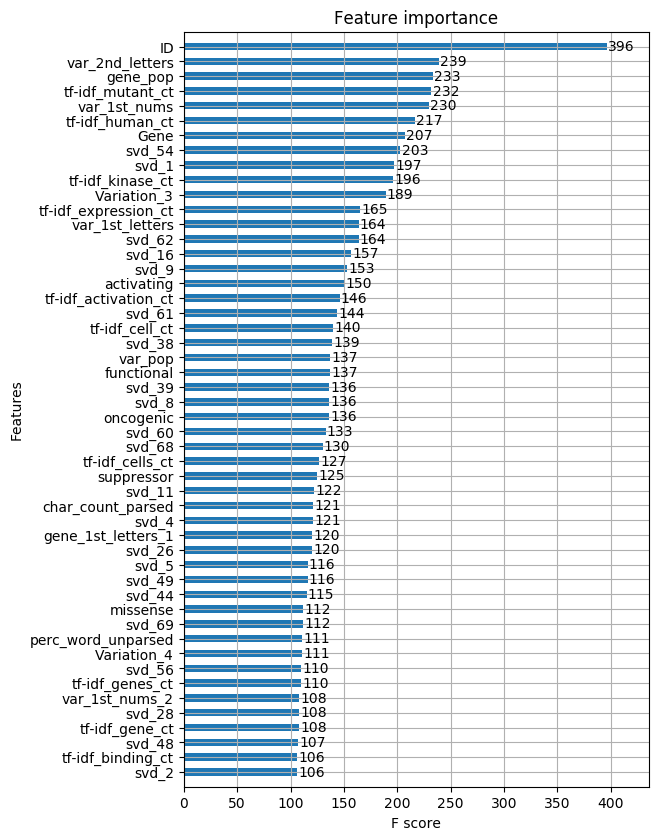

In [40]:
# separate train data into a CV train and test
x_train = train.drop(['Class'], axis=1)
x_test = train['Class']

# Begin training model with XGBoost
print('Start Training')

xgb_params = {
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'num_class' : 9,

    'eta': 0.05,
    'max_depth': 4,
    'min_child_weight': 3,
    'n_folds': 5,
    'silent': 1,    
}

dtrain = xgb.DMatrix(x_train, x_test)

early = 20
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=2000, early_stopping_rounds = early, verbose_eval=5)

num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round = int(num_boost_rounds / 0.80))

fig, ax = plt.subplots(1, 1, figsize=(6, 10))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

# *** V31 ***
# [260]	train-mlogloss:0.222816+0.00504889	test-mlogloss:0.89114+0.00404049
# Best CV: 0.899658871

In [41]:
# make predictions on test data
test_data = xgb.DMatrix(test)

y_predict = pd.concat([ID, pd.DataFrame(model.predict(test_data))], axis=1)
output = pd.DataFrame(y_predict)

output.columns = ['ID', 'class1', 'class2', 'class3', 'class4',
                  'class5', 'class6', 'class7', 'class8', 'class9']

output.to_csv('submission.csv', index=False)
print(output.head())

   ID    class1    class2    class3    class4    class5    class6    class7  \
0   0  0.023257  0.147237  0.001569  0.041890  0.035164  0.011385  0.737167   
1   1  0.058424  0.026803  0.001427  0.826028  0.022281  0.007202  0.055115   
2   2  0.024335  0.203753  0.004503  0.103217  0.017401  0.027637  0.611953   
3   3  0.017771  0.266462  0.000959  0.042387  0.035062  0.015187  0.613585   
4   4  0.055200  0.052438  0.000574  0.781984  0.006923  0.013374  0.085693   

     class8    class9  
0  0.001299  0.001032  
1  0.001786  0.000934  
2  0.003857  0.003343  
3  0.004096  0.004491  
4  0.000943  0.002872  
